# RNN(Numpy)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set()

np.random.seed(1)

## データ生成

In [32]:
# sin曲線+ノイズ
ts = np.linspace(0, 10 * np.pi, 500)
ys = np.sin(ts) + np.random.normal(scale=0.05, size=len(ts))

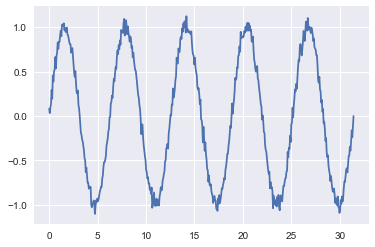

In [34]:
plt.plot(ts, ys)

In [35]:
# 学習設定
batch_size = 32     # ミニバッチサイズ
n_steps = 50          # 入力系列の長さ
input_size = 1        # 入力の次元
hidden_size = 10   #  中間層の次元
output_size = 1     # 出力層の次元

lr = 1e-5                  # 学習率(SGD)
n_iter = 1000           # イテレーション回数

In [36]:
# 訓練データとテストデータに分割
train_ratio = 0.8
data = []
for i in range(len(ys) - n_steps - 1):
    data.append(ys[i: i+n_steps+1])
data = np.array(data, dtype=np.float32)
n_train = int(train_ratio * len(data))
x_train, y_train = np.split(data[:n_train], [-1], axis=1)
x_test, y_test = np.split(data[n_train:], [-1], axis=1)

x_train = np.reshape(x_train, [-1, n_steps, input_size])
x_test = np.reshape(x_test, [-1, n_steps, input_size])

## モデル構築

In [38]:
# utility関数

def d_tanh_by_y(y):
    # y = tanh(x)の微分をyによって計算
    return 1 - y * y

def mean_squared_error(y, t):
    # 平均二乗誤差
    return np.mean(np.square(y - t))

def d_mean_squared_error(y, t):
    # 平均二乗誤差の微分
    return 2. * (y - t)

In [39]:
class Adam():
    # Adam optimizer
    def __init__(self, alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-08):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = {}
        self.v = {}
    
    def adam_grad(self, grad, tt, n):
        """
        adamにおける更新量を計算
        
        grad: gradient
        tt: train step
        n: param id
        """
        if n not in self.m:
            self.m[n] = np.zeros_like(grad)
            self.v[n] = np.zeros_like(grad)
        m, v = self.m[n], self.v[n]
        
        m += (1 - self.beta1) * (grad - m)
        v += (1 - self.beta2) * (grad * grad - v)
        
        fix1 = 1. - np.power(self.beta1, tt)
        fix2 = 1. - np.power(self.beta2, tt)
        lr = self.alpha * np.sqrt(fix2) / fix1
        return lr * m / (np.sqrt(v) + self.eps)

In [40]:
class RNN():

    def __init__(self, input_size, hidden_size, output_size, opt='adam', lr=None):
        # 各パラメータを初期化
        self.W_xh = np.random.normal(scale=init_scale(input_size), size=(hidden_size, input_size))
        self.W_hh = np.random.normal(scale=init_scale(hidden_size), size=(hidden_size, hidden_size))
        self.W_hy = np.random.normal(scale=init_scale(hidden_size), size=(output_size, hidden_size))
        self.b_h = np.zeros(hidden_size)
        self.b_y = np.zeros(output_size)
        
        self.hidden_size = hidden_size
        
        if opt == 'adam':
            self.adam = Adam()
            self.update = self.update_Adam
        else:
            self.update = self.update_SGD
            self.lr = lr  # 学習率(SGD)

    def forward(self, x):
        """
        順伝播
        x: (batch_size, n_steps, input_size)
        """
        batch_size, n_steps, input_size = x.shape
        x = np.transpose(x, [1, 0, 2])  # (n_steps, batch_size, input_size)
        
        # RNNの初期状態
        h = np.zeros([batch_size, self.hidden_size])
        hs = [h]
        # 系列順にRNN層に入力
        for xt in x:
            h = np.tanh(np.dot(xt, self.W_xh.T) + np.dot(h, self.W_hh.T) + self.b_h)
            hs.append(h)
        y = np.dot(h, self.W_hy.T) + self.b_y
        return y, hs

    def train_step(self, x, t, tt):
        """
        訓練1回（順伝播＋誤差逆伝播＋パラメータ更新）
        x: input
        t: label
        tt: #train step (for adam)
        """
        # 順伝播
        y, hs = self.forward(x)
        # 損失関数を計算
        loss = mean_squared_error(y, t)
        
        # 各パラメータについての勾配を初期化
        dW_xh, dW_hh, dW_hy = np.zeros_like(self.W_xh), np.zeros_like(self.W_hh), np.zeros_like(self.W_hy)
        db_h, db_y = np.zeros_like(self.b_h), np.zeros_like(self.b_y)
        
        # 誤差逆伝播
        # バッチサイズを考慮するので、コメントの式とは少し異なる
        dy = d_mean_squared_error(y, t) # dL/dy
        dW_hy += np.dot(dy.T, hs[-1])  # dL/dW_hy = dy ・ h^T
        db_y += np.sum(dy, axis=0)  # dL/db_y = dy
        du = np.dot(dy, self.W_hy) * d_tanh_by_y(hs[-1]) # dL/du = (W_hy^T ・ dy) f'(u)
        
        # Truncated BPTTのステップ数（ len(hs)+1ならFull BPTT ）
        bptt_steps = len(hs)
        for i in range(1, bptt_steps):
            dW_xh += np.dot(du.T, x[:, -i])  # dL/dW_xh = \sum du_{t} ・ x_{t}^T
            dW_hh += np.dot(du.T, hs[-i-1])  # dL/dW_hh = \sum du_{t} ・ h_{t-1}^T
            db_h += np.sum(du, axis=0)  # dL/db_h = \sum du_{t}
            du = np.dot(du, self.W_hh) * d_tanh_by_y(hs[-i-1])  # dL/du_{t-1} = (W_hh^T ・ du_{t}) f'(u_{t-1})
        
        # 計算した勾配を利用して各パラメータを更新
        self.update(tt, dW_xh, dW_hh, dW_hy, db_h, db_y)
        return loss
    
    def update_SGD(self, tt, dW_xh, dW_hh, dW_hy, db_h, db_y):
        # SGDで更新
        self.W_xh -= self.lr * dW_xh
        self.W_hh -= self.lr * dW_hh
        self.W_hy -= self.lr * dW_hy
        self.b_h -= self.lr * db_h
        self.b_y -= self.lr * db_y
    
    def update_Adam(self, tt, dW_xh, dW_hh, dW_hy, db_h, db_y):
        # Adamで更新
        self.W_xh -= self.adam.adam_grad(dW_xh, tt, 0)
        self.W_hh -= self.adam.adam_grad(dW_hh, tt, 1)
        self.W_hy -= self.adam.adam_grad(dW_hy, tt, 2)
        self.b_h -= self.adam.adam_grad(db_h, tt, 3)
        self.b_y -= self.adam.adam_grad(db_y, tt, 4)
    

def init_scale(in_size):
    # パラメータの初期化スケール
    return np.sqrt(1. / in_size)

In [41]:
# モデルをインスタンス化
model = RNN(input_size, hidden_size, output_size, opt='adam', lr=lr)

## 学習

In [42]:
# 訓練データのインデックスをランダムに
perm = np.random.permutation(len(x_train))

for i in range(n_iter):
    idx = (i * batch_size) % len(x_train)
    batch_x, batch_y = x_train[perm[idx: idx+batch_size]], y_train[perm[idx: idx+batch_size]]
    
    loss = model.train_step(batch_x, batch_y, i+1)
    if i % 50 == 0:
        print("step: {}, loss {:.5f}".format(i, loss))

step: 0, loss 0.53225
step: 50, loss 0.14484
step: 100, loss 0.07357
step: 150, loss 0.02824
step: 200, loss 0.01703
step: 250, loss 0.01244
step: 300, loss 0.00760
step: 350, loss 0.00750
step: 400, loss 0.00675
step: 450, loss 0.00774
step: 500, loss 0.00314
step: 550, loss 0.00218
step: 600, loss 0.00391
step: 650, loss 0.00444
step: 700, loss 0.00218
step: 750, loss 0.00159
step: 800, loss 0.00316
step: 850, loss 0.00238
step: 900, loss 0.00364
step: 950, loss 0.00354


## テスト

In [43]:
# テストデータに対する予測
prediction, _ = model.forward(x_test)

# 1次元配列に
prediction = prediction.reshape(-1)
true_y = y_test.reshape(-1)

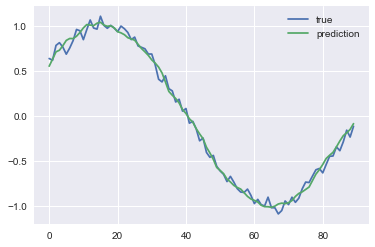

In [45]:
# テストデータに対する予測を可視化
xx = np.arange(len(prediction))
plt.plot(xx, true_y, label='true')
plt.plot(xx, prediction, label='prediction')
plt.legend()

## 再帰的な予測

In [46]:
# テストデータの最初のデータからスタートし、
# モデルの予測を利用し再帰的に予測
curr_x = x_test[0]
predicted = []
# 予測するステップ数
N = 200
for i in range(N):
    # 予測
    y, _ = model.forward(curr_x[None])
    predicted.append(y)
    # 入力を更新
    curr_x = np.insert(curr_x, n_steps, predicted[-1], axis=0)[1:]

# 1次元配列に
predicted = np.array(predicted).reshape(-1)

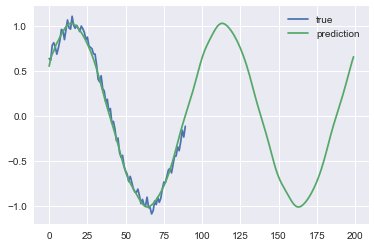

In [47]:
#再帰的な予測を可視化
plt.plot(xx, true_y, label='true')
plt.plot(np.arange(N), predicted, label='prediction')
plt.legend()